# Install required packages with compatible versions

In [1]:
# Install required packages with compatible versions
!pip uninstall -y numpy pandas scikit-learn xgboost optuna matplotlib seaborn scipy
!pip install numpy==1.26.4 pandas==2.2.3 scipy==1.15.2
!pip install scikit-learn==1.2.2 imbalanced-learn==0.12.3 xgboost==2.0.3 optuna==4.3.0 matplotlib==3.7.2 seaborn==0.12.2 lightgbm==4.5.0 catboost==1.2.7

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: xgboost 2.0.3
Uninstalling xgboost-2.0.3:
  Successfully uninstalled xgboost-2.0.3
Found existing installation: optuna 4.3.0
Uninstalling optuna-4.3.0:
  Successfully uninstalled optuna-4.3.0
Found existing installation: matplotlib 3.7.2
Uninstalling matplotlib-3.7.2:
  Successfully uninstalled matplotlib-3.7.2
Found existing installation: seaborn 0.12.2
Uninstalling seaborn-0.12.2:
  Successfully uninstalled seaborn-0.12.2
Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
     ━━━━

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import os

# Set plot style
plt.style.use('seaborn')
sns.set_palette('husl')

# Data loading

In [3]:
print("--- Starting Data Loading ---")
DATA_DIR = os.path.join(os.getcwd(), '/kaggle/input/playground-series-s5e7/')
TRAIN_FILE = os.path.join(DATA_DIR, 'train.csv')
TEST_FILE = os.path.join(DATA_DIR, 'test.csv')

--- Starting Data Loading ---


# Initialize dataframes

In [4]:
# Initialize dataframes
train_df = pd.DataFrame()
test_df = pd.DataFrame()

try:
    print(f"Loading train data from: {TRAIN_FILE}")
    train_df = pd.read_csv(TRAIN_FILE)
    print(f"Train data loaded. Shape: {train_df.shape}")
    print(f"Loading test data from: {TEST_FILE}")
    test_df = pd.read_csv(TEST_FILE)
    print(f"Test data loaded. Shape: {test_df.shape}")
    if 'Personality' in test_df.columns:
        test_df = test_df.drop('Personality', axis=1)
        print("Dropped 'Personality' column from test_df as it is the target variable.")
    if len(test_df) != 6175:
        print(f"Warning: Test set has {len(test_df)} rows, expected 6175. Check test.csv.")
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Store IDs
train_id = train_df['id']
test_id = test_df['id']

Loading train data from: /kaggle/input/playground-series-s5e7/train.csv
Train data loaded. Shape: (18524, 9)
Loading test data from: /kaggle/input/playground-series-s5e7/test.csv
Test data loaded. Shape: (6175, 8)


# Add Constant Feature

In [5]:
print("\n" + "="*50)
print("--- Adding Constant Feature to Synthetic Datasets ---")
print("="*50)
CONSTANT_FEATURE_NAME = 'constant_zero_feature'
CONSTANT_FEATURE_VALUE = 0
train_df[CONSTANT_FEATURE_NAME] = CONSTANT_FEATURE_VALUE
test_df[CONSTANT_FEATURE_NAME] = CONSTANT_FEATURE_VALUE
print(f"Added '{CONSTANT_FEATURE_NAME}' with value {CONSTANT_FEATURE_VALUE} to train_df and test_df.")
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")


--- Adding Constant Feature to Synthetic Datasets ---
Added 'constant_zero_feature' with value 0 to train_df and test_df.
Train data shape: (18524, 10)
Test data shape: (6175, 9)


# Add Constant Feature

In [6]:
print("\n" + "="*50)
print("--- Applying Missing Value Imputation ---")
print("="*50)

# Numerical Imputation
numerical_cols = train_df.select_dtypes(include=np.number).columns.drop(['id', 'Personality', CONSTANT_FEATURE_NAME], errors='ignore').tolist()
imputer = IterativeImputer(max_iter=10, random_state=42)
for df_name, df_obj in [('train_df', train_df), ('test_df', test_df)]:
    current_numerical_cols = [col for col in numerical_cols if col in df_obj.columns and df_obj[col].isnull().any()]
    if current_numerical_cols:
        print(f"Imputing numerical missing values in {df_name} for columns: {current_numerical_cols}")
        if df_name == 'train_df':
            df_obj[current_numerical_cols] = imputer.fit_transform(df_obj[current_numerical_cols])
        else:
            df_obj[current_numerical_cols] = imputer.transform(df_obj[current_numerical_cols])
    else:
        print(f"No numerical missing values to impute in {df_name}.")

# Categorical Imputation
categorical_cols = train_df.select_dtypes(include='object').columns.drop('Personality', errors='ignore').tolist()
for col in categorical_cols:
    if train_df[col].isnull().any():
        train_df[col] = train_df[col].fillna('Missing')
        print(f"Filled missing values in train_df[{col}] with 'Missing'.")
    if test_df[col].isnull().any():
        test_df[col] = test_df[col].fillna('Missing')
        print(f"Filled missing values in test_df[{col}] with 'Missing'.")


--- Applying Missing Value Imputation ---
Imputing numerical missing values in train_df for columns: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Imputing numerical missing values in test_df for columns: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Filled missing values in train_df[Stage_fear] with 'Missing'.
Filled missing values in test_df[Stage_fear] with 'Missing'.
Filled missing values in train_df[Drained_after_socializing] with 'Missing'.
Filled missing values in test_df[Drained_after_socializing] with 'Missing'.


# Feature Engineering

In [7]:
print("\n" + "="*50)
print("--- Feature Engineering ---")
print("="*50)

# Preserve original categorical columns for target encoding and EDA
train_df_original = train_df.copy()
test_df_original = test_df.copy()

# Target encoding for categorical features
for col in categorical_cols:
    target_mean = train_df_original.groupby(col)['Personality'].apply(lambda x: (x == 'Extrovert').mean())
    train_df[f'{col}_target_enc'] = train_df_original[col].map(target_mean)
    test_df[f'{col}_target_enc'] = test_df_original[col].map(target_mean).fillna(target_mean.mean())
    numerical_cols.append(f'{col}_target_enc')

# One-Hot Encoding
print("Applying One-Hot Encoding to categorical features.")
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=False)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=False)

# Align columns
train_feature_cols = [col for col in train_df.columns if col not in ['id', 'Personality']]
test_feature_cols = [col for col in test_df.columns if col not in ['id']]
all_features_union = sorted(list(set(train_feature_cols) | set(test_feature_cols)))
original_train_id = train_df['id']
original_train_personality = train_df['Personality']
original_test_id = test_df['id']
train_df = train_df.reindex(columns=all_features_union + ['id', 'Personality'], fill_value=0)
test_df = test_df.reindex(columns=all_features_union + ['id'], fill_value=0)
train_df['id'] = original_train_id
train_df['Personality'] = original_train_personality
test_df['id'] = original_test_id
print("Columns aligned after One-Hot Encoding.")

# Interaction terms for top numerical features
numerical_cols_no_target = [col for col in numerical_cols if col != 'Personality']
if len(numerical_cols_no_target) >= 2:
    for i in range(min(2, len(numerical_cols_no_target))):
        for j in range(i + 1, min(2, len(numerical_cols_no_target))):
            col1, col2 = numerical_cols_no_target[i], numerical_cols_no_target[j]
            train_df[f'{col1}_{col2}_inter'] = train_df[col1] * train_df[col2]
            test_df[f'{col1}_{col2}_inter'] = test_df[col1] * test_df[col2]
            numerical_cols.append(f'{col1}_{col2}_inter')

# Polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
if len(numerical_cols_no_target) >= 2:
    top_cols = numerical_cols_no_target[:2]
    poly_features = poly.fit_transform(train_df[top_cols])
    poly_feature_names = poly.get_feature_names_out(top_cols)
    train_df[poly_feature_names] = poly_features
    test_df[poly_feature_names] = poly.transform(test_df[top_cols])
    numerical_cols.extend(poly_feature_names)

# Scale numerical features
scaler = StandardScaler()
train_df[numerical_cols_no_target] = scaler.fit_transform(train_df[numerical_cols_no_target])
test_df[numerical_cols_no_target] = scaler.transform(test_df[numerical_cols_no_target])


--- Feature Engineering ---
Applying One-Hot Encoding to categorical features.
Columns aligned after One-Hot Encoding.


# Data Description

In [8]:
print("\n" + "="*50)
print("--- Data Description ---")
print("="*50)

print("\n1. Train Dataset Overview:")
print(f"Shape: {train_df.shape}")
print(f"Columns: {list(train_df.columns)}")
print("\n2. Test Dataset Overview:")
print(f"Shape: {test_df.shape}")
print(f"Columns: {list(test_df.columns)}")

print("\n3. Column Data Types (Train):")
print(train_df.dtypes)
print("\n4. Column Data Types (Test):")
print(test_df.dtypes)

print("\n5. Missing Values (Train):")
print(train_df.isnull().sum())
print(f"Total missing values: {train_df.isnull().sum().sum()}")
print("\n6. Missing Values (Test):")
print(test_df.isnull().sum())
print(f"Total missing values: {test_df.isnull().sum().sum()}")

print("\n7. Summary Statistics for Numerical Features (Train):")
print(train_df[numerical_cols].describe())
print("\n8. Summary Statistics for Numerical Features (Test):")
print(test_df[[col for col in numerical_cols if col in test_df.columns]].describe())

print("\n9. Categorical Features and Unique Values (Train):")
for col in categorical_cols:
    print(f"{col}: {train_df_original[col].nunique()} unique values")
    print(f"Sample values: {train_df_original[col].unique()[:5]}")
print("\n10. Categorical Features and Unique Values (Test):")
for col in categorical_cols:
    print(f"{col}: {test_df_original[col].nunique()} unique values")
    print(f"Sample values: {test_df_original[col].unique()[:5]}")

print("\n11. Target Variable Distribution (Train):")
print(train_df['Personality'].value_counts(normalize=True))
print(f"Unique target values: {train_df['Personality'].unique()}")

# --- Exploratory Data Analysis ---
print("\n" + "="*50)
print("--- Exploratory Data Analysis ---")
print("="*50)


--- Data Description ---

1. Train Dataset Overview:
Shape: (18524, 20)
Columns: ['Drained_after_socializing_Missing', 'Drained_after_socializing_No', 'Drained_after_socializing_Yes', 'Drained_after_socializing_target_enc', 'Friends_circle_size', 'Going_outside', 'Post_frequency', 'Social_event_attendance', 'Stage_fear_Missing', 'Stage_fear_No', 'Stage_fear_Yes', 'Stage_fear_target_enc', 'Time_spent_Alone', 'constant_zero_feature', 'id', 'Personality', 'Time_spent_Alone_Social_event_attendance_inter', 'Time_spent_Alone^2', 'Time_spent_Alone Social_event_attendance', 'Social_event_attendance^2']

2. Test Dataset Overview:
Shape: (6175, 19)
Columns: ['Drained_after_socializing_Missing', 'Drained_after_socializing_No', 'Drained_after_socializing_Yes', 'Drained_after_socializing_target_enc', 'Friends_circle_size', 'Going_outside', 'Post_frequency', 'Social_event_attendance', 'Stage_fear_Missing', 'Stage_fear_No', 'Stage_fear_Yes', 'Stage_fear_target_enc', 'Time_spent_Alone', 'constant_zer

# Analysis

### 1. Target Variable Distribution

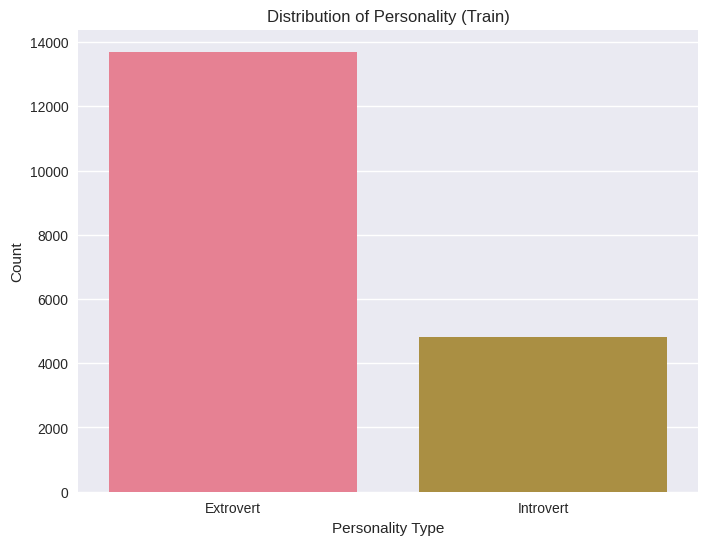


Class Imbalance Check:
Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Personality', data=train_df)
plt.title('Distribution of Personality (Train)')
plt.xlabel('Personality Type')
plt.ylabel('Count')
plt.show()
print("\nClass Imbalance Check:")
print(train_df['Personality'].value_counts(normalize=True))

### 2. Numerical Features


Numerical Features: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency', 'Stage_fear_target_enc', 'Drained_after_socializing_target_enc', 'Time_spent_Alone_Social_event_attendance_inter', 'Time_spent_Alone', 'Social_event_attendance', 'Time_spent_Alone^2', 'Time_spent_Alone Social_event_attendance', 'Social_event_attendance^2']


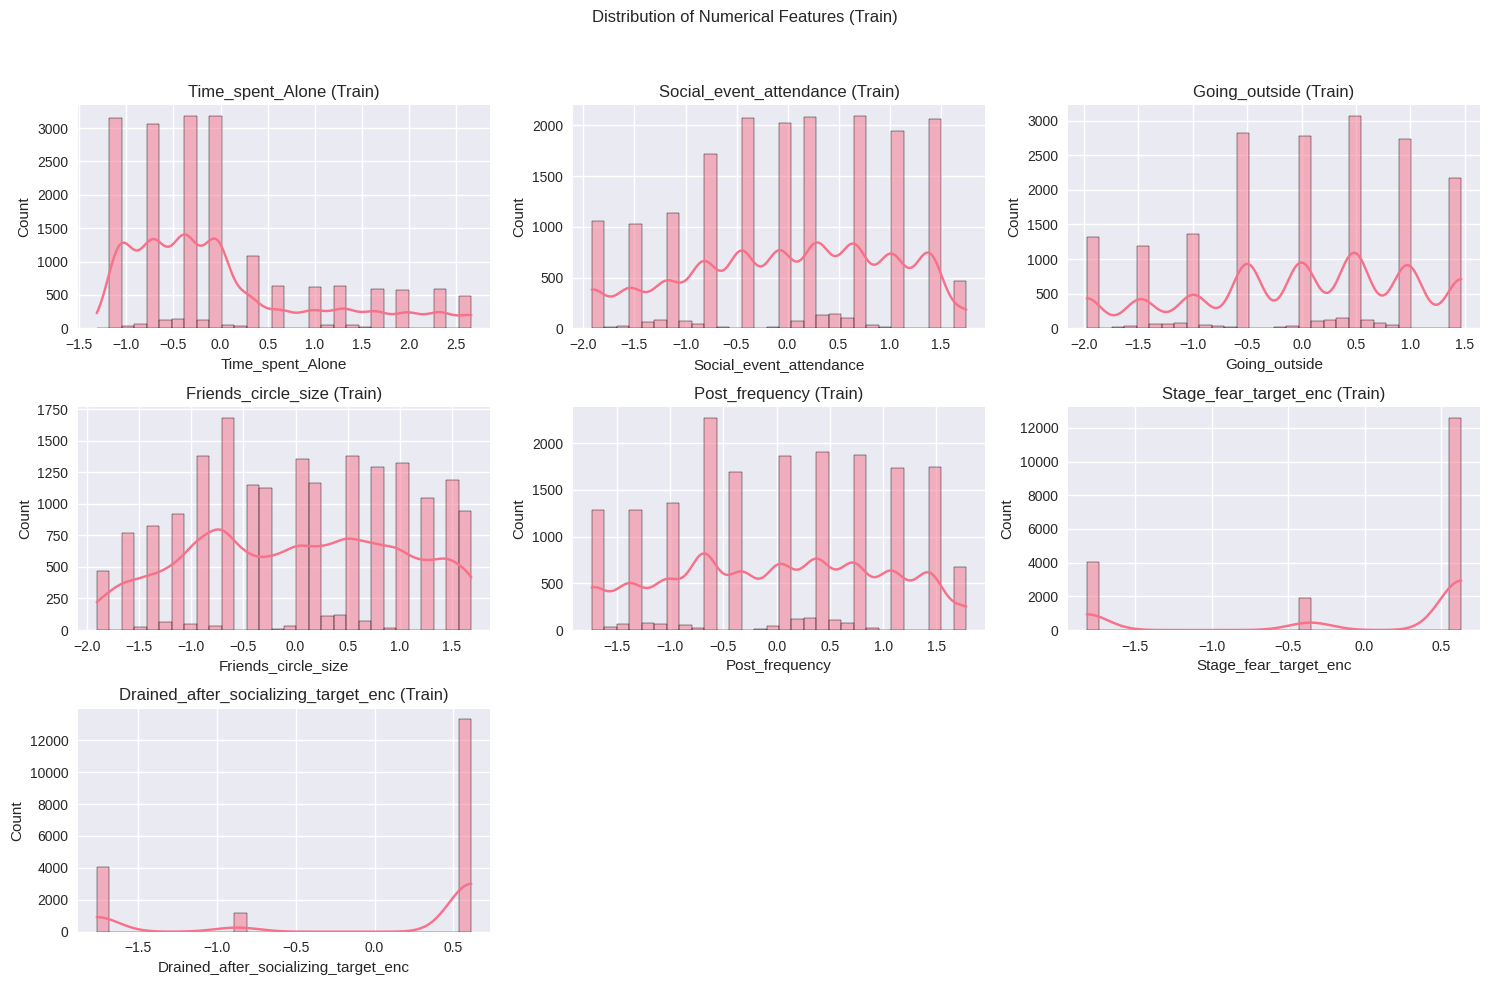

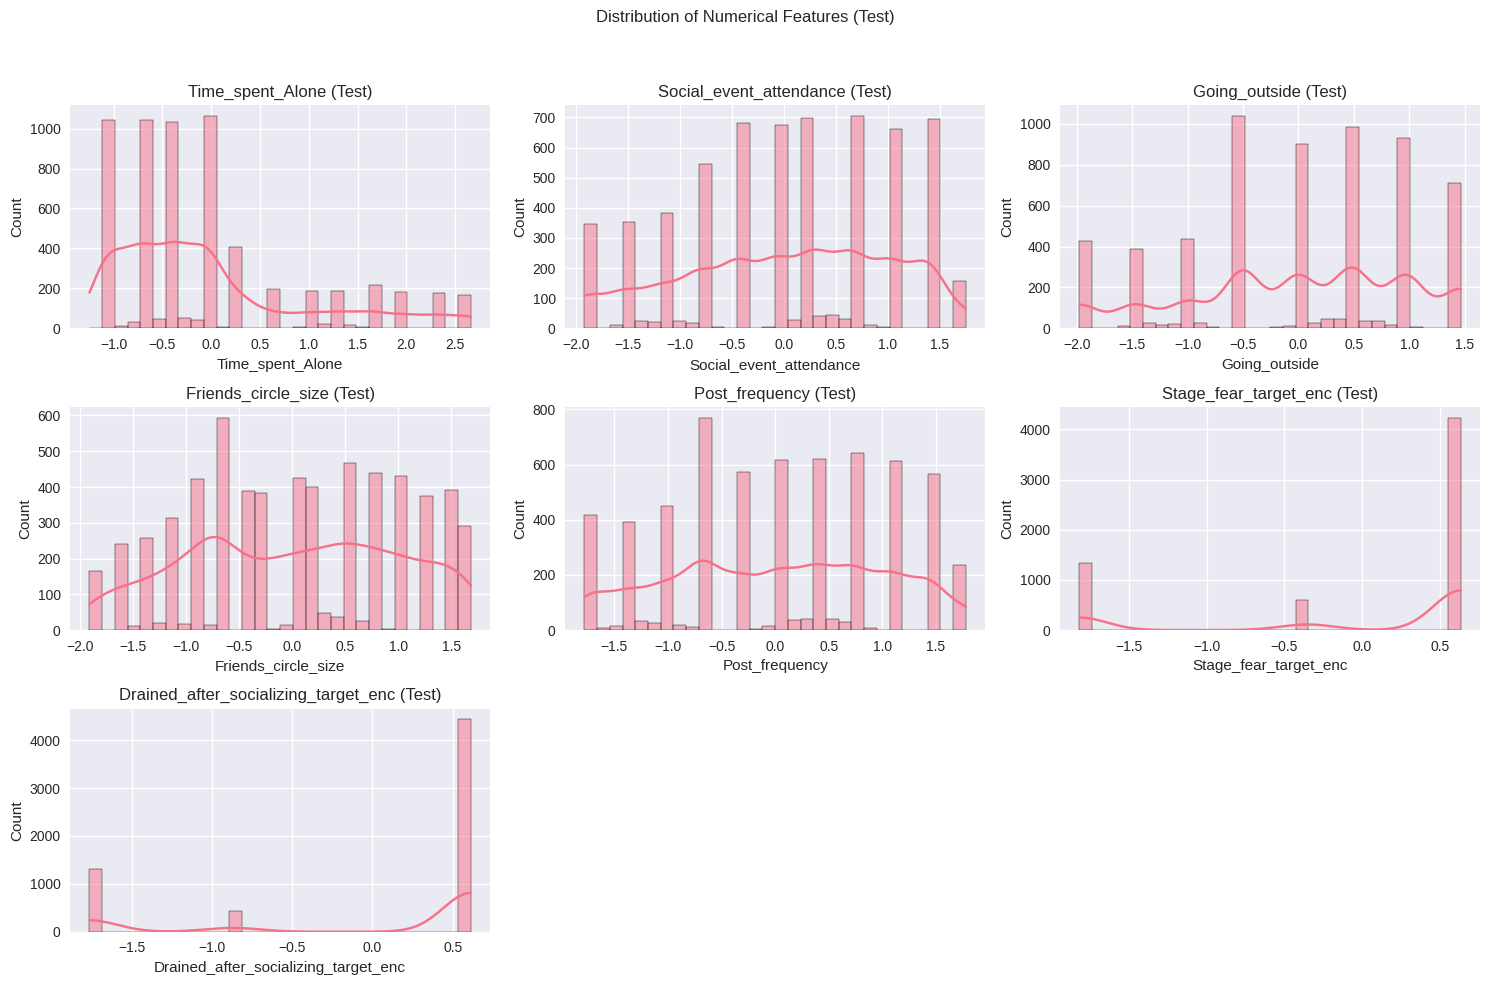

In [25]:
print("\nNumerical Features:", numerical_cols)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_no_target, 1):
    plt.subplot((len(numerical_cols_no_target)//3 + 1), 3, i)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(f'{col} (Train)')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.suptitle('Distribution of Numerical Features (Train)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_no_target, 1):
    plt.subplot((len(numerical_cols_no_target)//3 + 1), 3, i)
    sns.histplot(test_df[col], bins=30, kde=True)
    plt.title(f'{col} (Test)')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.suptitle('Distribution of Numerical Features (Test)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 3. Pair Plots of Numerical Features


Generating Pair Plots for Top Numerical Features (Train and Test)


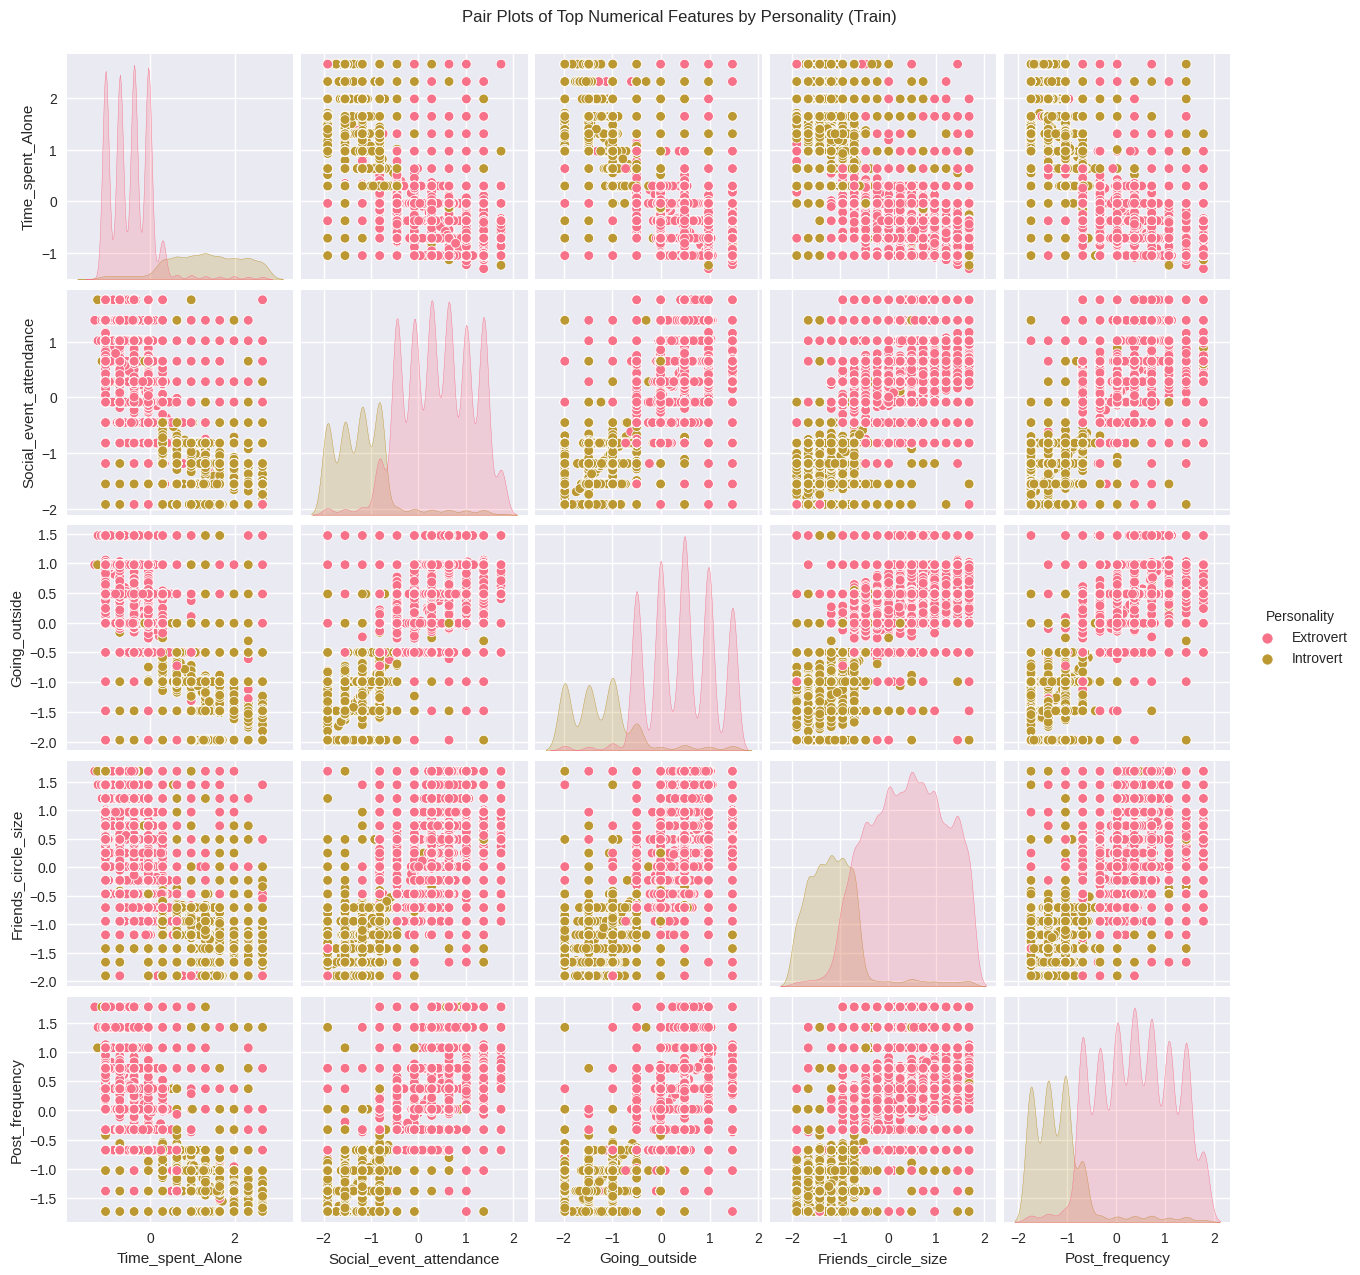

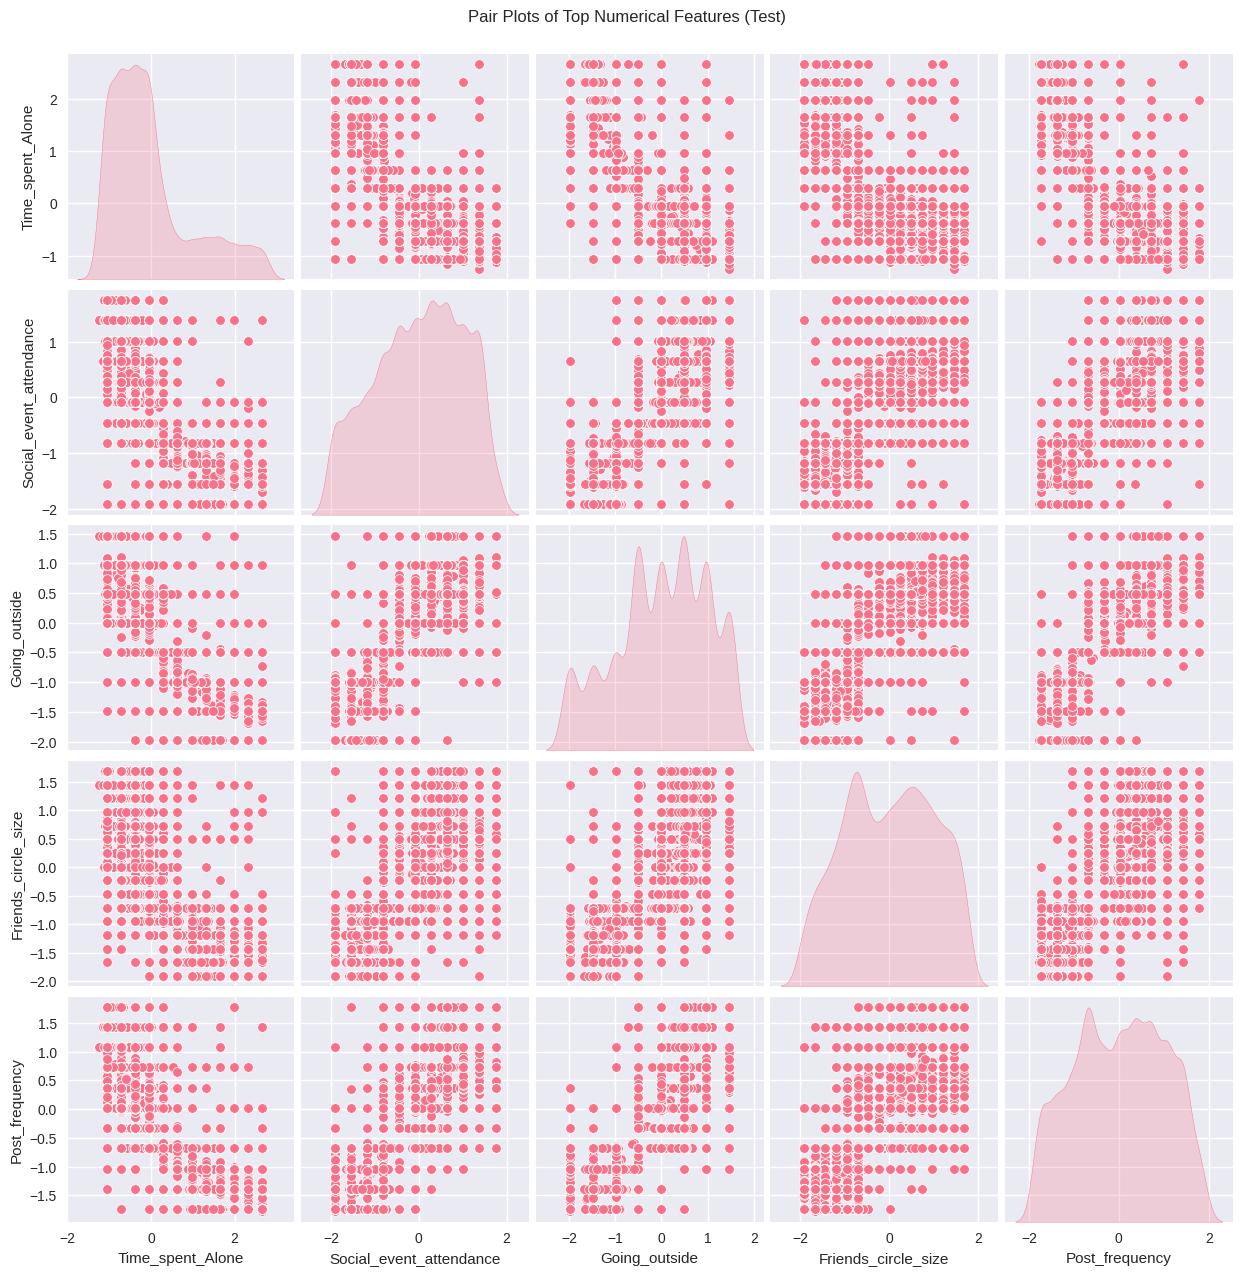

In [30]:
# 5. Pair Plots of Numerical Features
print("\nGenerating Pair Plots for Top Numerical Features (Train and Test)")
# Select top 4 numerical features to avoid excessive computation
top_numerical_cols = numerical_cols_no_target[:5]
if len(top_numerical_cols) > 0:
    # Pair plots for training set
    pair_plot_df_train = train_df[top_numerical_cols + ['Personality']].copy()
    sns.pairplot(pair_plot_df_train, hue='Personality', diag_kind='kde')
    plt.suptitle('Pair Plots of Top Numerical Features by Personality (Train)', y=1.02)
    plt.show()
    
    # Pair plots for test set
    pair_plot_df_test = test_df[top_numerical_cols].copy()
    sns.pairplot(pair_plot_df_test, diag_kind='kde')
    plt.suptitle('Pair Plots of Top Numerical Features (Test)', y=1.02)
    plt.show()
else:
    print("No numerical features available for pair plots.")

### 4. Outlier Analysis


Outliers in Training Set:
Time_spent_Alone: 1653 outliers
Social_event_attendance: 0 outliers
Going_outside: 0 outliers
Friends_circle_size: 0 outliers
Post_frequency: 0 outliers
Stage_fear_target_enc: 0 outliers
Drained_after_socializing_target_enc: 0 outliers

Outliers in Test Set:
Time_spent_Alone: 529 outliers
Social_event_attendance: 0 outliers
Going_outside: 0 outliers
Friends_circle_size: 0 outliers
Post_frequency: 0 outliers
Stage_fear_target_enc: 0 outliers
Drained_after_socializing_target_enc: 0 outliers


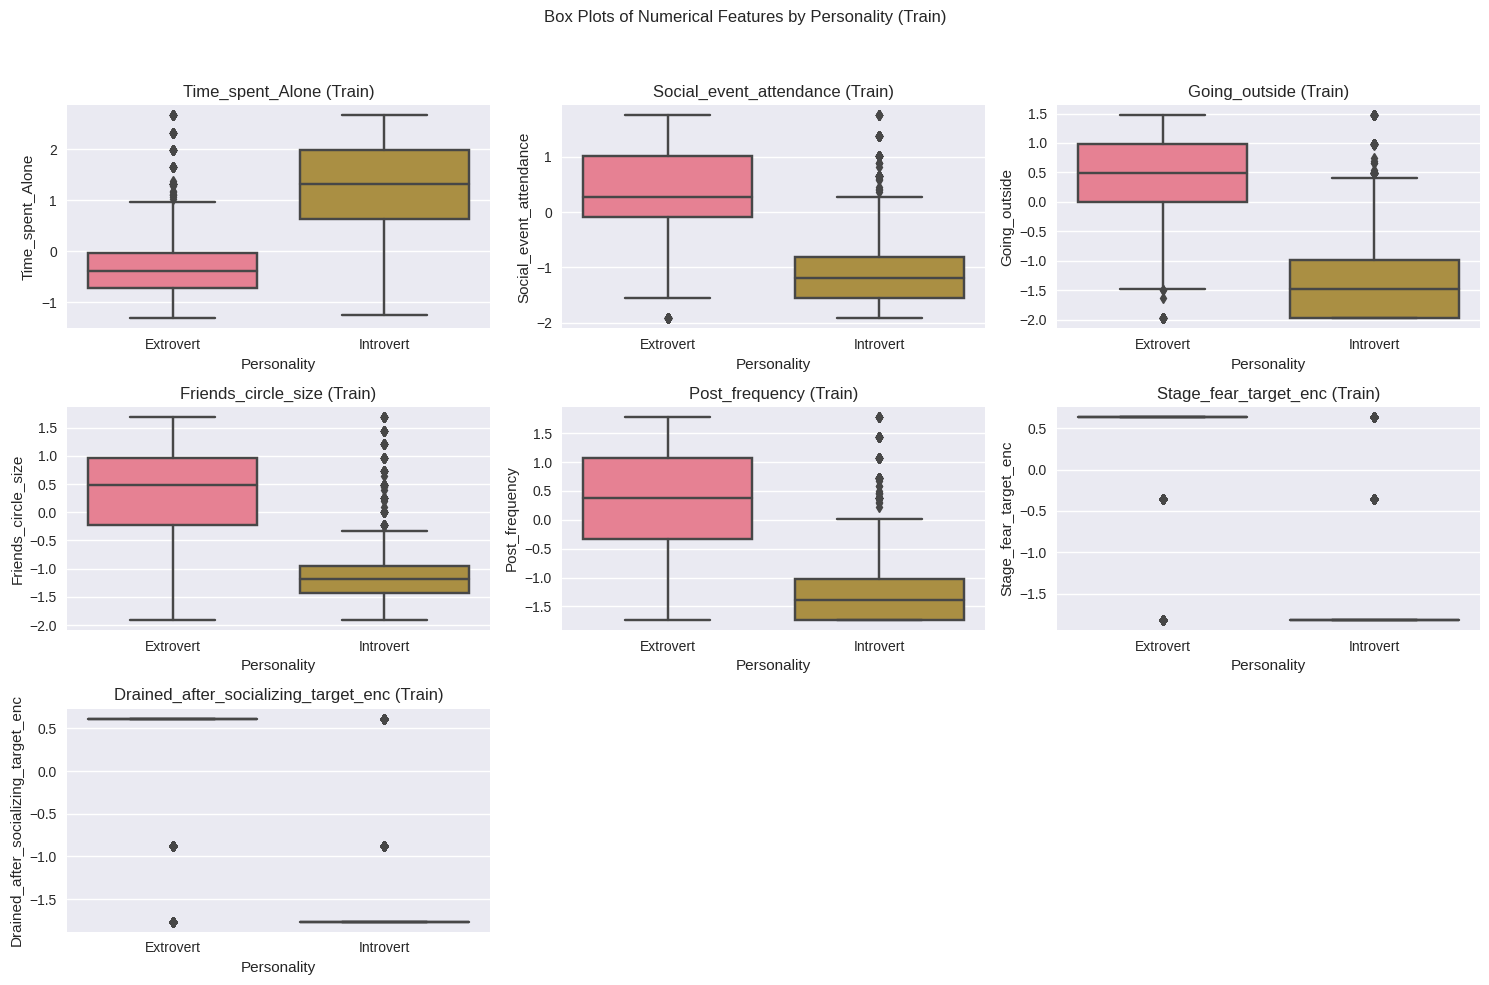

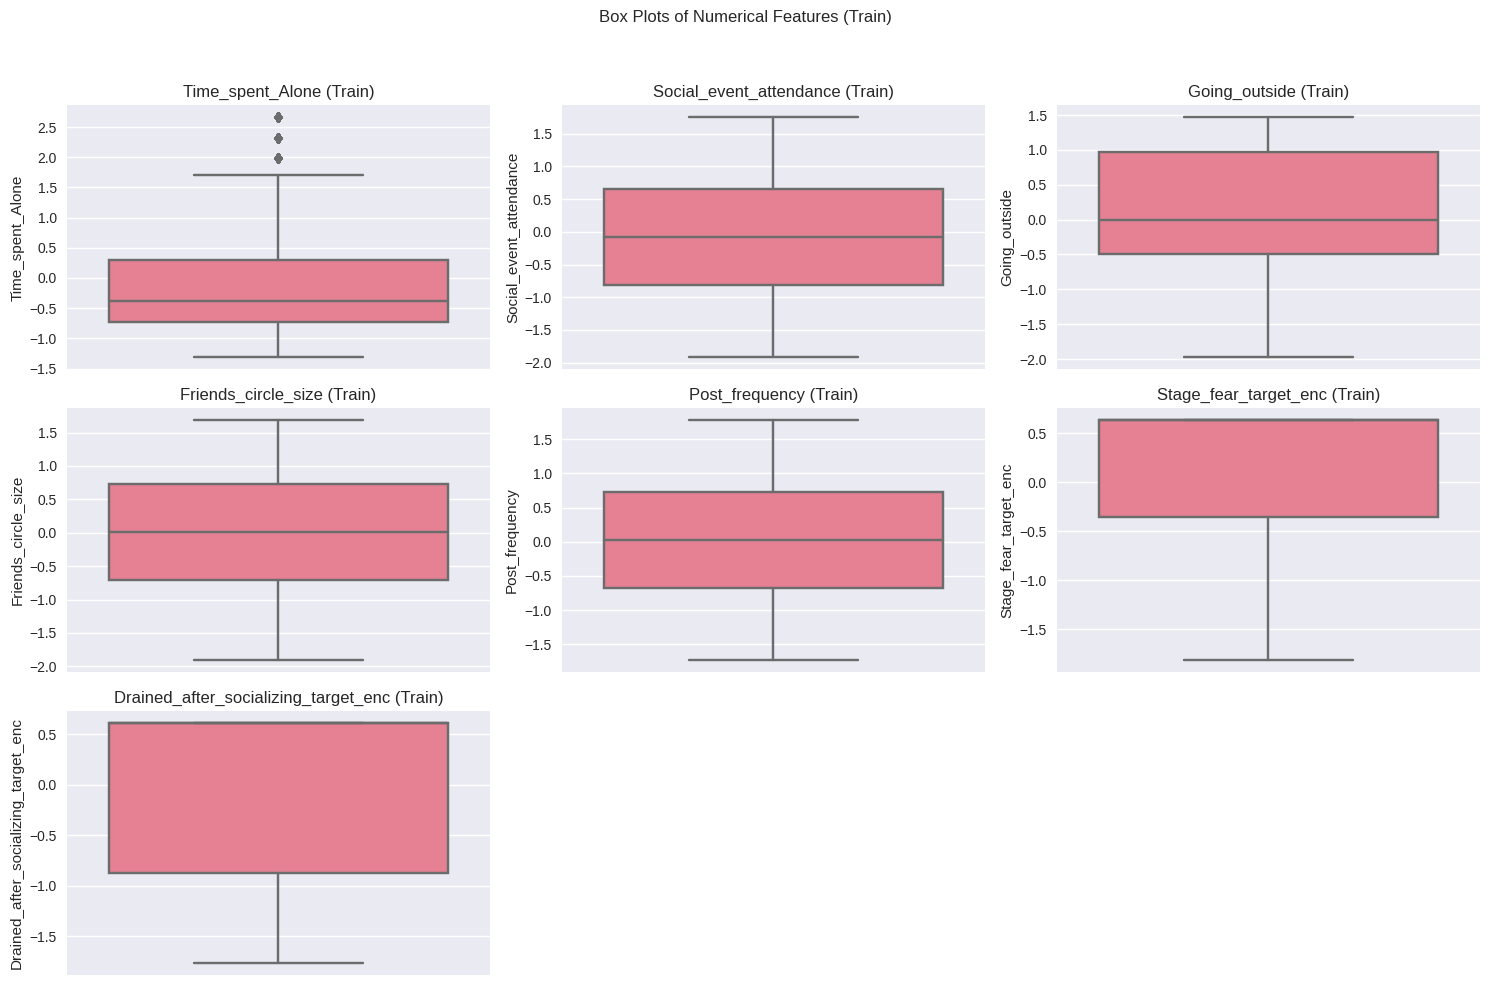

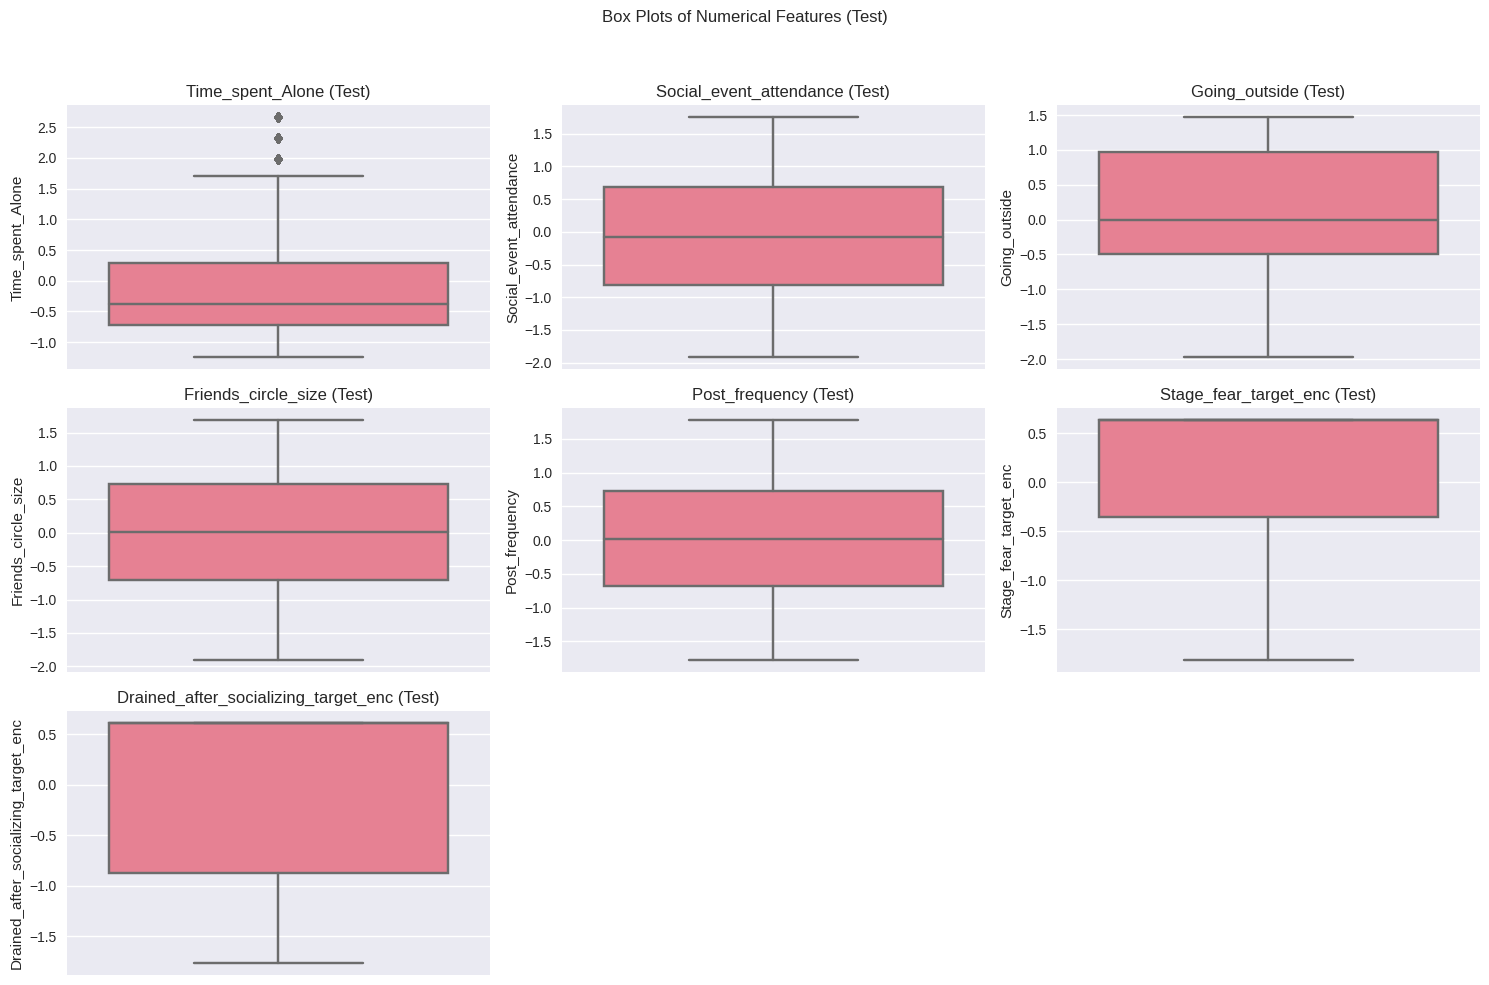

In [26]:
def detect_outliers(df, columns):
    outliers_count = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_count[col] = len(outliers)
    return outliers_count

# Detect outliers in train and test sets
print("\nOutliers in Training Set:")
train_outliers = detect_outliers(train_df, numerical_cols_no_target)
for col, count in train_outliers.items():
    print(f"{col}: {count} outliers")

print("\nOutliers in Test Set:")
test_outliers = detect_outliers(test_df, numerical_cols_no_target)
for col, count in test_outliers.items():
    print(f"{col}: {count} outliers")

# Box plots for training set with hue by Personality
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_no_target, 1):
    plt.subplot((len(numerical_cols_no_target)//3 + 1), 3, i)
    sns.boxplot(x='Personality', y=col, data=train_df)
    plt.title(f'{col} (Train)')
plt.suptitle('Box Plots of Numerical Features by Personality (Train)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_no_target, 1):
    plt.subplot((len(numerical_cols_no_target)//3 + 1), 3, i)
    sns.boxplot(y=train_df[col])
    plt.title(f'{col} (Train)')
plt.suptitle('Box Plots of Numerical Features (Train)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_no_target, 1):
    plt.subplot((len(numerical_cols_no_target)//3 + 1), 3, i)
    sns.boxplot(y=test_df[col])
    plt.title(f'{col} (Test)')
plt.suptitle('Box Plots of Numerical Features (Test)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 4. Categorical Features


Categorical Features: ['Stage_fear', 'Drained_after_socializing']


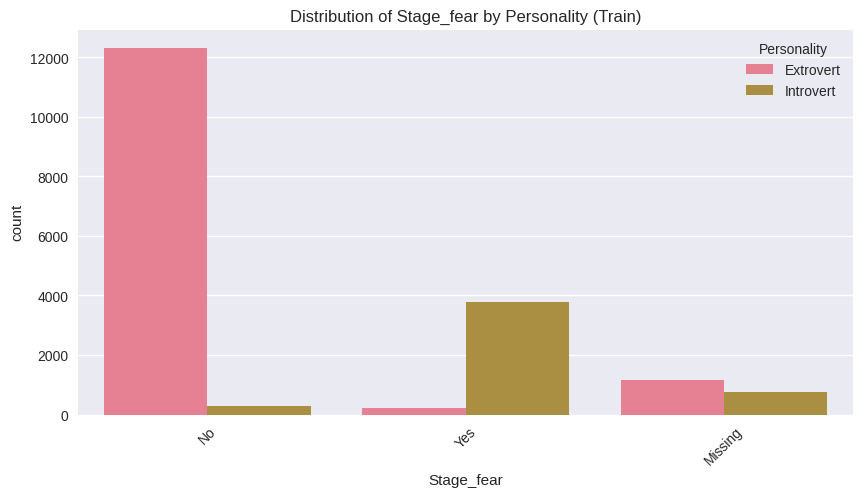

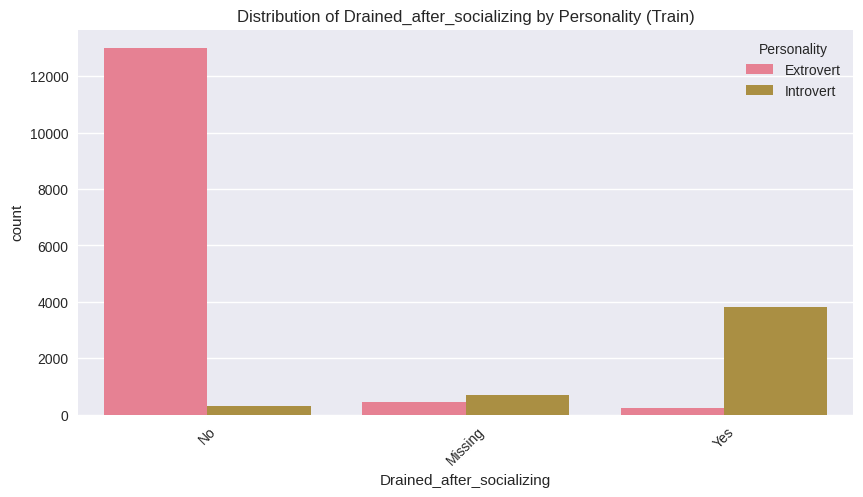

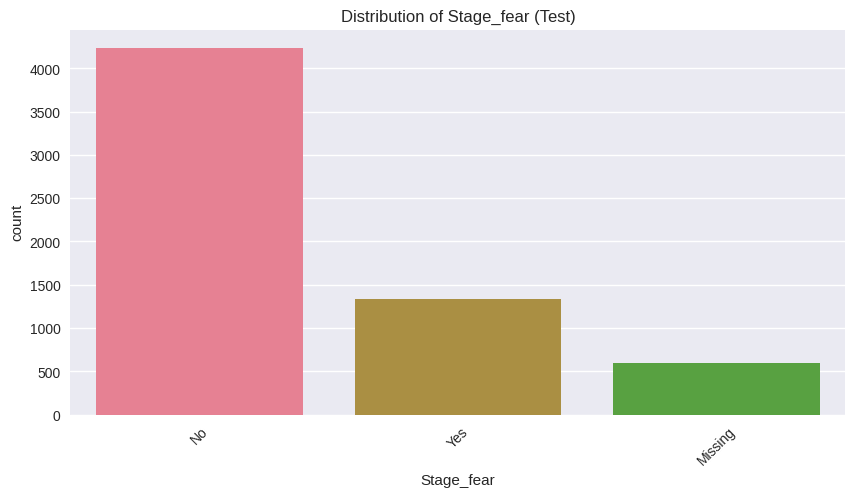

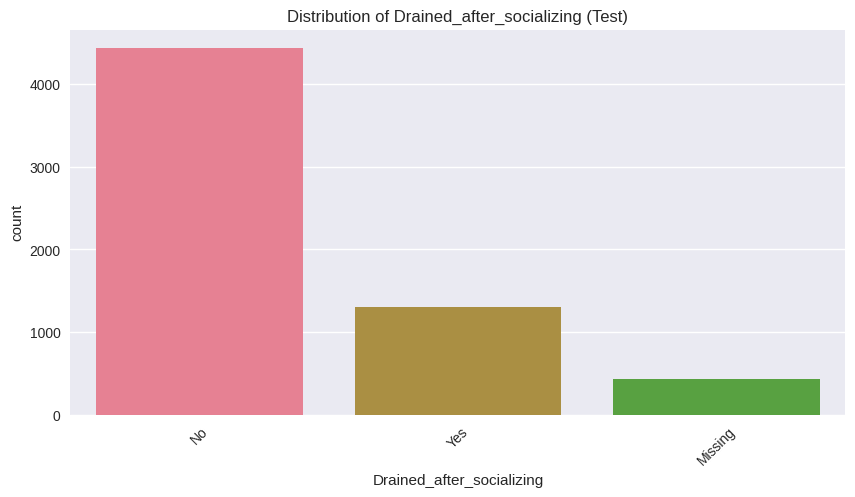

In [12]:
print("\nCategorical Features:", categorical_cols)
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='Personality', data=train_df_original)
    plt.title(f'Distribution of {col} by Personality (Train)')
    plt.xticks(rotation=45)
    plt.show()

for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=test_df_original)
    plt.title(f'Distribution of {col} (Test)')
    plt.xticks(rotation=45)
    plt.show()

### 5. Correlation Analysis

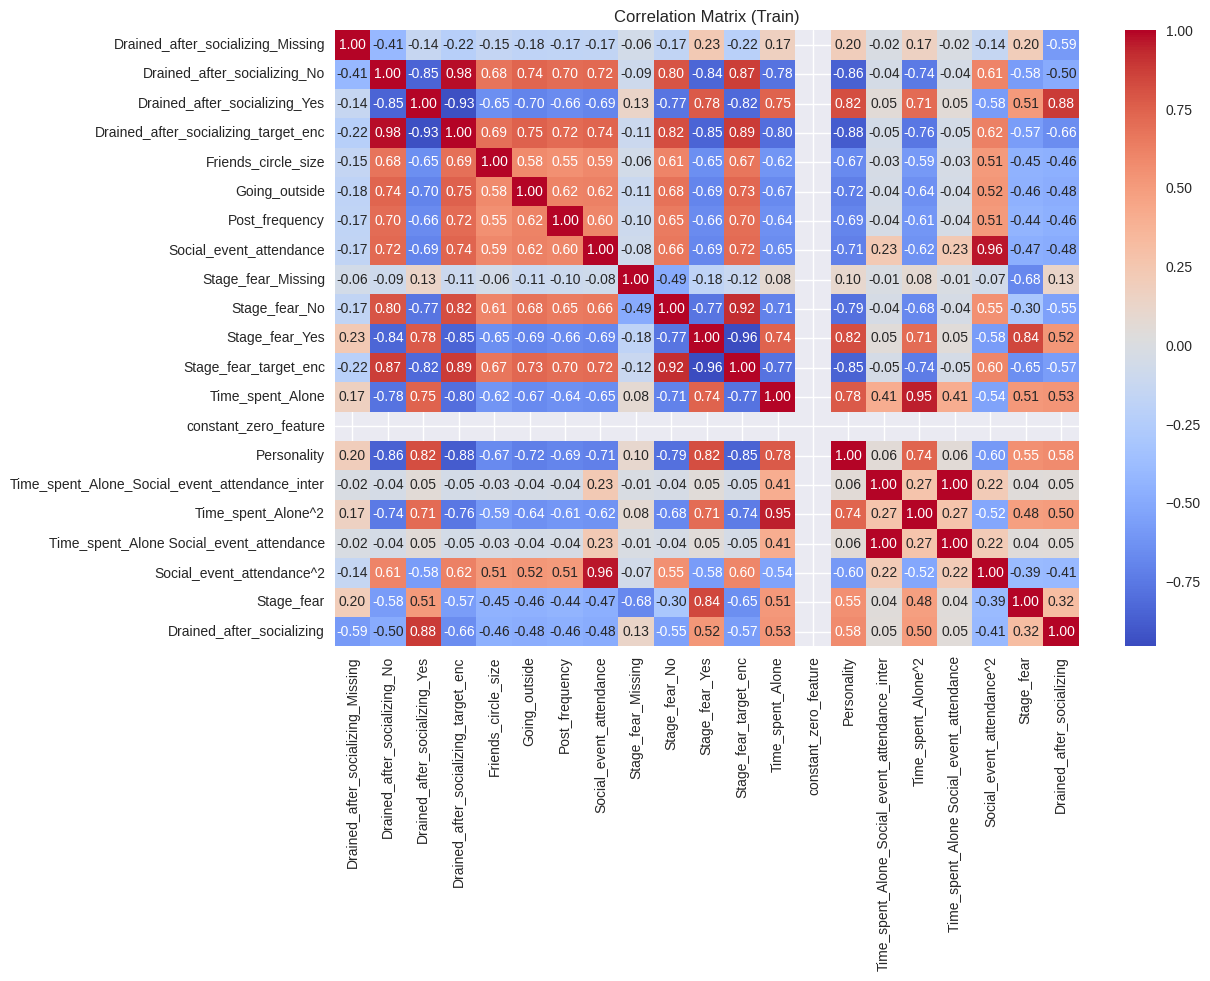

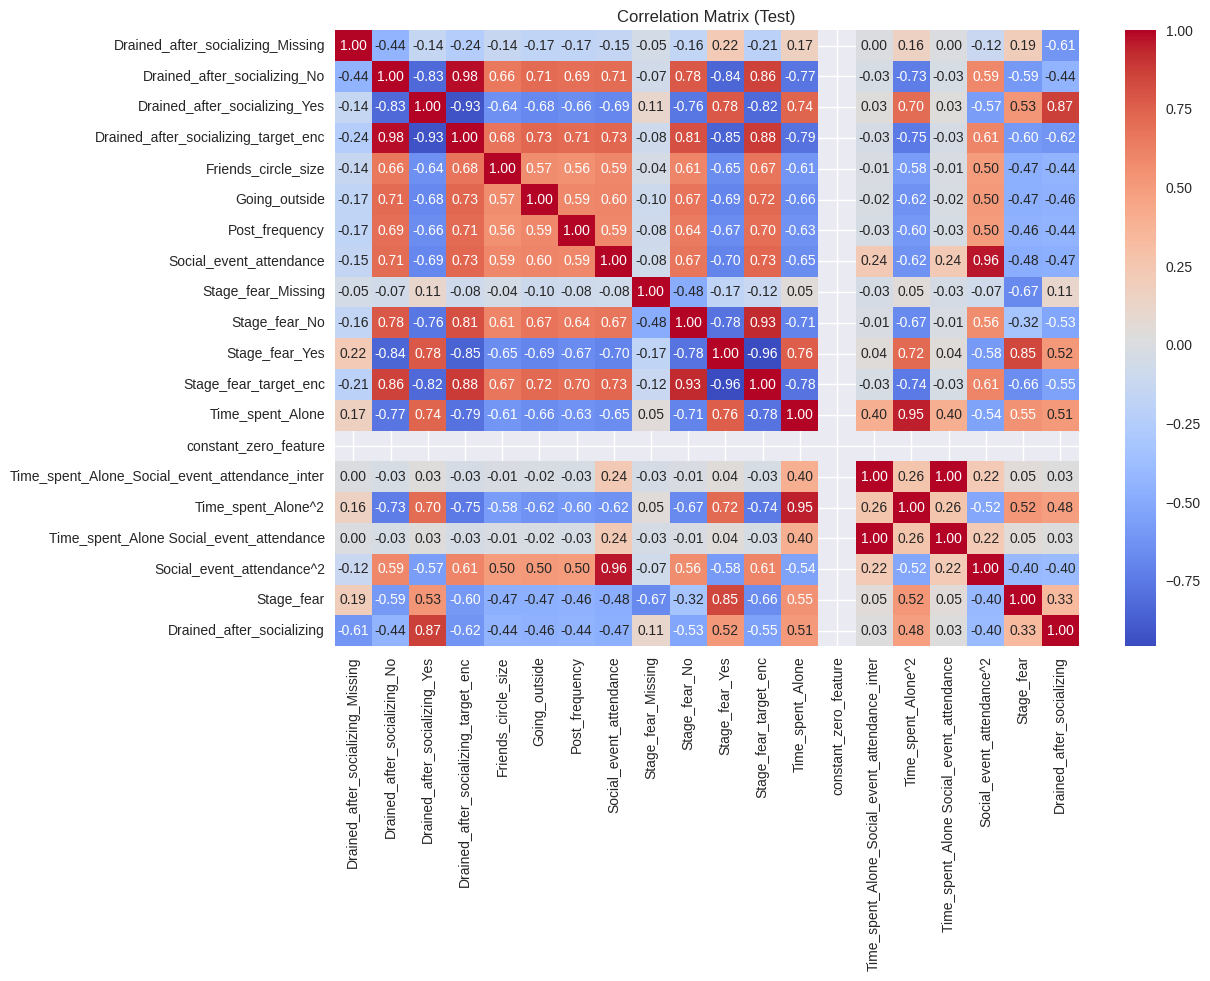

In [13]:
encoded_train = train_df.copy()
encoded_test = test_df.copy()

# Use a dictionary to store a separate LabelEncoder for each column
label_encoders = {}
for col in categorical_cols + ['Personality']:
    if col in train_df_original.columns:
        le = LabelEncoder()
        encoded_train[col] = le.fit_transform(train_df_original[col].astype(str))
        label_encoders[col] = le

for col in categorical_cols:
    if col in test_df_original.columns:
        le = label_encoders.get(col, LabelEncoder())
        # Get unique values in train and test
        train_values = set(train_df_original[col].astype(str).unique())
        test_values = set(test_df_original[col].astype(str).unique())
        unseen_values = test_values - train_values
        if unseen_values:
            print(f"Warning: Unseen values {unseen_values} in test_df_original[{col}]. Mapping to most common training value.")
            most_common = train_df_original[col].mode()[0]
            encoded_test[col] = test_df_original[col].astype(str).map(lambda x: x if x in train_values else most_common)
        else:
            encoded_test[col] = test_df_original[col].astype(str)
        encoded_test[col] = le.transform(encoded_test[col])

plt.figure(figsize=(12, 8))
sns.heatmap(encoded_train.drop('id', axis=1).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Train)')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(encoded_test.drop('id', axis=1).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Test)')
plt.show()

# Prepare Data for Modeling

In [14]:
TARGET = 'Personality'
if TARGET not in train_df.columns:
    raise KeyError(f"'{TARGET}' not found in train_df.")
y = train_df[TARGET]
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"\nTarget variable encoded: {le_target.classes_} mapped to {le_target.transform(le_target.classes_)}")

FEATURES = [col for col in train_df.columns if col not in ['id', TARGET]]
X = train_df[FEATURES]
X_test = test_df[FEATURES]

# Handle class imbalance
class_ratio = train_df['Personality'].value_counts(normalize=True)
class_weights = {0: 1 / class_ratio['Extrovert'], 1: 1 / class_ratio['Introvert']}

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


Target variable encoded: ['Extrovert' 'Introvert'] mapped to [0 1]


# Optimize Probability Threshold

In [15]:
def optimize_threshold(model, X_val, y_val):
    thresholds = np.arange(0.3, 0.8, 0.05)
    best_threshold = 0.5
    best_score = 0
    for threshold in thresholds:
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = (y_pred_proba > threshold).astype(int)
        score = accuracy_score(y_val, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    return best_threshold, best_score

# Hyperparameter Tuning

### XGBClassifier

In [16]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=[class_weights[y] for y in y_train])
    best_threshold, best_score = optimize_threshold(model, X_val, y_val)
    return best_score

### LGBMClassifier

In [17]:
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, sample_weight=[class_weights[y] for y in y_train])
    best_threshold, best_score = optimize_threshold(model, X_val, y_val)
    return best_score

### CatBoostClassifier

In [18]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_seed': 42,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, sample_weight=[class_weights[y] for y in y_train])
    best_threshold, best_score = optimize_threshold(model, X_val, y_val)
    return best_score

In [19]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=30)

# Train models with best parameters
best_params_xgb = study_xgb.best_params
best_params_xgb.update({'random_state': 42})
best_params_lgb = study_lgb.best_params
best_params_lgb.update({'random_state': 42})
best_params_cat = study_cat.best_params
best_params_cat.update({'random_seed': 42, 'verbose': 0})

model_xgb = XGBClassifier(**best_params_xgb)
model_lgb = LGBMClassifier(**best_params_lgb)
model_cat = CatBoostClassifier(**best_params_cat)

# Optimize ensemble weights
def objective_ensemble(trial):
    w_xgb = trial.suggest_float('w_xgb', 0, 1)
    w_lgb = trial.suggest_float('w_lgb', 0, 1)
    w_cat = trial.suggest_float('w_cat', 0, 1)
    w_sum = w_xgb + w_lgb + w_cat
    if w_sum == 0:
        return 0
    w_xgb, w_lgb, w_cat = w_xgb / w_sum, w_lgb / w_sum, w_cat / w_sum
    y_pred_proba = (w_xgb * model_xgb.predict_proba(X_val)[:, 1] +
                    w_lgb * model_lgb.predict_proba(X_val)[:, 1] +
                    w_cat * model_cat.predict_proba(X_val)[:, 1])
    thresholds = np.arange(0.3, 0.8, 0.05)
    best_score = 0
    for threshold in thresholds:
        y_pred = (y_pred_proba > threshold).astype(int)
        score = accuracy_score(y_val, y_pred)
        if score > best_score:
            best_score = score
    return best_score

[I 2025-07-02 09:34:09,360] A new study created in memory with name: no-name-63846b2c-d8cc-4be7-b200-169a7f3786d4
[I 2025-07-02 09:34:09,985] Trial 0 finished with value: 0.97165991902834 and parameters: {'n_estimators': 232, 'max_depth': 8, 'learning_rate': 0.012665896216075704, 'subsample': 0.7007534984651563, 'colsample_bytree': 0.8405284428738865, 'reg_alpha': 0.16420355750124016, 'reg_lambda': 0.9877862703152078, 'gamma': 0.3938362386992894, 'min_child_weight': 10}. Best is trial 0 with value: 0.97165991902834.
[I 2025-07-02 09:34:11,056] Trial 1 finished with value: 0.97165991902834 and parameters: {'n_estimators': 330, 'max_depth': 4, 'learning_rate': 0.009412230238602921, 'subsample': 0.8833991927746272, 'colsample_bytree': 0.8310303496727325, 'reg_alpha': 0.8390190021334429, 'reg_lambda': 1.284165743855971, 'gamma': 0.7419775222792252, 'min_child_weight': 1}. Best is trial 0 with value: 0.97165991902834.
[I 2025-07-02 09:34:12,155] Trial 2 finished with value: 0.97139001349527

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:34:34,860] Trial 0 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 374, 'max_depth': 3, 'learning_rate': 0.08486943835937921, 'subsample': 0.8510938125209158, 'colsample_bytree': 0.8472668739276557, 'reg_alpha': 1.377253602688516, 'reg_lambda': 0.571964864220357, 'min_child_weight': 9}. Best is trial 0 with value: 0.9713900134952766.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:34:35,384] Trial 1 finished with value: 0.9719298245614035 and parameters: {'n_estimators': 230, 'max_depth': 8, 'learning_rate': 0.006398199675781742, 'subsample': 0.5041544668885294, 'colsample_bytree': 0.5024221696746157, 'reg_alpha': 1.7101190453577622, 'reg_lambda': 0.5452659122589838, 'min_child_weight': 2}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:34:39,148] Trial 2 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 910, 'max_depth': 8, 'learning_rate': 0.03773616712286362, 'subsample': 0.510457968379328, 'colsample_bytree': 0.6045998007178922, 'reg_alpha': 1.6356207792342334, 'reg_lambda': 0.5236157420713117, 'min_child_weight': 9}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:34:42,506] Trial 3 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 953, 'max_depth': 6, 'learning_rate': 0.020328304512768566, 'subsample': 0.6045352292984618, 'colsample_bytree': 0.9037945451620553, 'reg_alpha': 0.4688134361650298, 'reg_lambda': 0.34424277807042514, 'min_child_weight': 3}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:34:43,272] Trial 4 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 466, 'max_depth': 3, 'learning_rate': 0.01730221504478081, 'subsample': 0.620454369742855, 'colsample_bytree': 0.6480600939861731, 'reg_alpha': 0.141352694743895, 'reg_lambda': 0.929510476395665, 'min_child_weight': 3}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:34:45,146] Trial 5 finished with value: 0.97165991902834 and parameters: {'n_estimators': 568, 'max_depth': 6, 'learning_rate': 0.018312532641739297, 'subsample': 0.9230368773835089, 'colsample_bytree': 0.7118862597076204, 'reg_alpha': 0.6992206559887721, 'reg_lambda': 0.24250774473816072, 'min_child_weight': 10}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:34:46,278] Trial 6 finished with value: 0.9708502024291498 and parameters: {'n_estimators': 410, 'max_depth': 5, 'learning_rate': 0.25128896863351324, 'subsample': 0.9633408325364611, 'colsample_bytree': 0.568152123527535, 'reg_alpha': 0.22534828971296217, 'reg_lambda': 1.141904095187256, 'min_child_weight': 10}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:34:47,776] Trial 7 finished with value: 0.9700404858299595 and parameters: {'n_estimators': 466, 'max_depth': 6, 'learning_rate': 0.1884000469274995, 'subsample': 0.598168778959141, 'colsample_bytree': 0.7855992728883959, 'reg_alpha': 1.6833611740143442, 'reg_lambda': 1.2385402654640865, 'min_child_weight': 3}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:34:49,119] Trial 8 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 414, 'max_depth': 7, 'learning_rate': 0.009887885501816823, 'subsample': 0.5291284845486588, 'colsample_bytree': 0.5372793810730199, 'reg_alpha': 0.3839059822412194, 'reg_lambda': 1.2967542793115274, 'min_child_weight': 3}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:34:52,008] Trial 9 finished with value: 0.9711201079622133 and parameters: {'n_estimators': 770, 'max_depth': 7, 'learning_rate': 0.04171158930094336, 'subsample': 0.786729637322098, 'colsample_bytree': 0.7571784726617344, 'reg_alpha': 1.882522632579798, 'reg_lambda': 0.4131022408860534, 'min_child_weight': 8}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:34:52,296] Trial 10 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 124, 'max_depth': 8, 'learning_rate': 0.005473629049216594, 'subsample': 0.7203212668884558, 'colsample_bytree': 0.5057232283055809, 'reg_alpha': 1.1154886159552733, 'reg_lambda': 1.8770729011449214, 'min_child_weight': 1}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:34:54,043] Trial 11 finished with value: 0.97165991902834 and parameters: {'n_estimators': 669, 'max_depth': 5, 'learning_rate': 0.00623642363767818, 'subsample': 0.9812515395218976, 'colsample_bytree': 0.9833189616420226, 'reg_alpha': 0.817965708206779, 'reg_lambda': 0.003951311431645732, 'min_child_weight': 6}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:34:54,373] Trial 12 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 152, 'max_depth': 4, 'learning_rate': 0.011009923928624508, 'subsample': 0.8769386841490552, 'colsample_bytree': 0.6845217462839288, 'reg_alpha': 0.7693321728370778, 'reg_lambda': 0.08031311022811027, 'min_child_weight': 6}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:34:55,227] Trial 13 finished with value: 0.97165991902834 and parameters: {'n_estimators': 247, 'max_depth': 7, 'learning_rate': 0.0250934883180649, 'subsample': 0.70540873286379, 'colsample_bytree': 0.6951607949863269, 'reg_alpha': 1.1979848975663878, 'reg_lambda': 0.8198412453559945, 'min_child_weight': 1}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:34:57,876] Trial 14 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 628, 'max_depth': 8, 'learning_rate': 0.010458511571707213, 'subsample': 0.8958801910170671, 'colsample_bytree': 0.619155087594242, 'reg_alpha': 0.7152244529608686, 'reg_lambda': 0.7327028687482869, 'min_child_weight': 5}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:34:58,901] Trial 15 finished with value: 0.9711201079622133 and parameters: {'n_estimators': 281, 'max_depth': 6, 'learning_rate': 0.07911661603677704, 'subsample': 0.8045818811243903, 'colsample_bytree': 0.8462125255051276, 'reg_alpha': 1.3779032913944318, 'reg_lambda': 0.19566814445367342, 'min_child_weight': 7}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:35:00,220] Trial 16 finished with value: 0.97165991902834 and parameters: {'n_estimators': 594, 'max_depth': 4, 'learning_rate': 0.013962199143563165, 'subsample': 0.660198666517461, 'colsample_bytree': 0.7102150455587307, 'reg_alpha': 0.9435293185779263, 'reg_lambda': 1.5141217140998524, 'min_child_weight': 5}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:35:02,597] Trial 17 finished with value: 0.97165991902834 and parameters: {'n_estimators': 758, 'max_depth': 7, 'learning_rate': 0.007213613629080986, 'subsample': 0.9408224874842845, 'colsample_bytree': 0.9887685982602958, 'reg_alpha': 1.929411268141121, 'reg_lambda': 0.2762189651177347, 'min_child_weight': 4}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:35:03,326] Trial 18 finished with value: 0.97165991902834 and parameters: {'n_estimators': 268, 'max_depth': 5, 'learning_rate': 0.0311204430144215, 'subsample': 0.8074106999289801, 'colsample_bytree': 0.7928609240958235, 'reg_alpha': 0.5397179380519683, 'reg_lambda': 0.691196948101716, 'min_child_weight': 7}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:35:05,391] Trial 19 finished with value: 0.9708502024291498 and parameters: {'n_estimators': 542, 'max_depth': 8, 'learning_rate': 0.06756267240313636, 'subsample': 0.7525690690322911, 'colsample_bytree': 0.5776281907079032, 'reg_alpha': 1.3514664569139627, 'reg_lambda': 0.42766304549028733, 'min_child_weight': 10}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:35:06,934] Trial 20 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 721, 'max_depth': 4, 'learning_rate': 0.00868416459641974, 'subsample': 0.5458920593060338, 'colsample_bytree': 0.5105221081241382, 'reg_alpha': 1.6195133479915835, 'reg_lambda': 0.15606049442297976, 'min_child_weight': 2}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:35:08,626] Trial 21 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 687, 'max_depth': 5, 'learning_rate': 0.005033304694374878, 'subsample': 0.97781602831667, 'colsample_bytree': 0.9921227570570448, 'reg_alpha': 0.8635348541744086, 'reg_lambda': 0.01058523546199604, 'min_child_weight': 6}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:35:10,298] Trial 22 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 553, 'max_depth': 6, 'learning_rate': 0.007479624837056285, 'subsample': 0.9166052472433464, 'colsample_bytree': 0.8876901304602967, 'reg_alpha': 0.6287671958135965, 'reg_lambda': 0.2711504247411851, 'min_child_weight': 8}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:35:12,594] Trial 23 finished with value: 0.97165991902834 and parameters: {'n_estimators': 822, 'max_depth': 5, 'learning_rate': 0.014650555696725995, 'subsample': 0.844529004784487, 'colsample_bytree': 0.9376299432969271, 'reg_alpha': 1.0275534907434274, 'reg_lambda': 0.015764832850089117, 'min_child_weight': 4}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:35:13,934] Trial 24 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 659, 'max_depth': 4, 'learning_rate': 0.00631758139494177, 'subsample': 0.9919369269727213, 'colsample_bytree': 0.6517110019197819, 'reg_alpha': 0.012248472928362952, 'reg_lambda': 0.6081010068256114, 'min_child_weight': 7}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:35:15,673] Trial 25 finished with value: 0.97165991902834 and parameters: {'n_estimators': 504, 'max_depth': 7, 'learning_rate': 0.012677681571673373, 'subsample': 0.9391018227074656, 'colsample_bytree': 0.7412374323693354, 'reg_alpha': 0.8735372474070332, 'reg_lambda': 0.4426270510491204, 'min_child_weight': 2}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:35:16,763] Trial 26 finished with value: 0.97165991902834 and parameters: {'n_estimators': 344, 'max_depth': 6, 'learning_rate': 0.01989024667635137, 'subsample': 0.8740954722646831, 'colsample_bytree': 0.8062254393440614, 'reg_alpha': 1.2143171050280188, 'reg_lambda': 0.22995434477600105, 'min_child_weight': 9}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:35:18,258] Trial 27 finished with value: 0.97165991902834 and parameters: {'n_estimators': 592, 'max_depth': 5, 'learning_rate': 0.007897989052436993, 'subsample': 0.9206490317296876, 'colsample_bytree': 0.951699424356886, 'reg_alpha': 0.6747582064814874, 'reg_lambda': 0.13960922286334287, 'min_child_weight': 4}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:35:21,245] Trial 28 finished with value: 0.97165991902834 and parameters: {'n_estimators': 834, 'max_depth': 6, 'learning_rate': 0.05406624377805065, 'subsample': 0.6798180448628066, 'colsample_bytree': 0.7331991169400265, 'reg_alpha': 0.309799556176277, 'reg_lambda': 0.9329284233468358, 'min_child_weight': 8}. Best is trial 1 with value: 0.9719298245614035.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-02 09:35:21,910] Trial 29 finished with value: 0.9713900134952766 and parameters: {'n_estimators': 204, 'max_depth': 7, 'learning_rate': 0.025062930594115254, 'subsample': 0.8513800477794085, 'colsample_bytree': 0.8517925022376659, 'reg_alpha': 1.5282516131343065, 'reg_lambda': 0.5881138568364335, 'min_child_weight': 6}. Best is trial 1 with value: 0.9719298245614035.
[I 2025-07-02 09:35:21,912] A new study created in memory with name: no-name-56a701fa-407b-42e0-bc81-53d591e9c3fc
[I 2025-07-02 09:35:22,349] Trial 0 finished with value: 0.9719298245614035 and parameters: {'iterations': 181, 'depth': 4, 'learning_rate': 0.08496148956689321, 'l2_leaf_reg': 9.490554589248719, 'border_count': 49, 'bagging_temperature': 0.01098876940205129}. Best is trial 0 with value: 0.9719298245614035.
[I 2025-07-02 09:35:26,319] Trial 1 finished with value: 0.9721997300944669 and parameters: {'iterations': 949, 'depth': 5, 'learning_rate': 0.024598777733046993, 'l2_leaf_reg': 4.076887070921018

# Train models for ensemble optimization

In [20]:
# Train models for ensemble optimization
model_xgb.fit(X_train, y_train, sample_weight=[class_weights[y] for y in y_train])
model_lgb.fit(X_train, y_train, sample_weight=[class_weights[y] for y in y_train])
model_cat.fit(X_train, y_train, sample_weight=[class_weights[y] for y in y_train])

study_ensemble = optuna.create_study(direction='maximize')
study_ensemble.optimize(objective_ensemble, n_trials=30)
best_weights = study_ensemble.best_params
w_sum = best_weights['w_xgb'] + best_weights['w_lgb'] + best_weights['w_cat']
best_weights = {
    'w_xgb': best_weights['w_xgb'] / w_sum,
    'w_lgb': best_weights['w_lgb'] / w_sum,
    'w_cat': best_weights['w_cat'] / w_sum
}
print("\nBest Ensemble Weights:", best_weights)

# Optimize ensemble threshold
def optimize_ensemble_threshold(X_val, y_val):
    y_pred_proba = (best_weights['w_xgb'] * model_xgb.predict_proba(X_val)[:, 1] +
                    best_weights['w_lgb'] * model_lgb.predict_proba(X_val)[:, 1] +
                    best_weights['w_cat'] * model_cat.predict_proba(X_val)[:, 1])
    thresholds = np.arange(0.3, 0.8, 0.05)
    best_threshold = 0.5
    best_score = 0
    for threshold in thresholds:
        y_pred = (y_pred_proba > threshold).astype(int)
        score = accuracy_score(y_val, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    return best_threshold, best_score

threshold_ensemble, score_ensemble = optimize_ensemble_threshold(X_val, y_val)
print(f"Ensemble: Threshold={threshold_ensemble:.2f}, Accuracy={score_ensemble:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-02 09:36:43,203] A new study created in memory with name: no-name-cc8e1d5a-212a-40bc-ac41-3eaab26ccc65
[I 2025-07-02 09:36:43,250] Trial 0 finished with value: 0.97165991902834 and parameters: {'w_xgb': 0.4607054222873026, 'w_lgb': 0.21501231156168632, 'w_cat': 0.26350329576050735}. Best is trial 0 with value: 0.97165991902834.
[I 2025-07-02 09:36:43,301] Trial 1 finished with value: 0.9719298245614035 and parameters: {'w_xgb': 0.2435826336357797, 'w_lgb': 0.4713630466667623, 'w_cat': 0.8930529169542808}. Best is trial 1 with value: 0.9719298245614035.
[I 2025-07-02 09:36:43,348] Trial 2 finished with value: 0.9719298245614035 and parameters: {'w_xgb': 0.8723938890133344, 'w_lgb': 0.22033036041308596, 'w_cat': 0.5825713481522474}. Best is trial 1 with value: 0.9719298245614035.
[I 2025-07-02 09:36:43,395] Trial 3 finished with value: 0.9719298245614035 and parameters: {'w_xgb': 0.6448417500339348, 'w_lgb': 0.001088976898114824, 'w_cat': 0.5486302476836903}. Best is trial 1 w


Best Ensemble Weights: {'w_xgb': 0.15386354241569788, 'w_lgb': 0.270285614674088, 'w_cat': 0.5758508429102142}
Ensemble: Threshold=0.75, Accuracy=0.9722


# Final Model Training and CV

In [21]:
print("\n" + "="*50)
print("--- Final Model Training and Evaluation ---")
print("="*50)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(y_encoded))
test_preds_folds = []
fold_accuracies = []
feature_importances_sum = np.zeros(len(FEATURES))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_encoded)):
    print(f"Training Fold {fold+1}/5...")
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y_encoded[train_idx], y_encoded[val_idx]
    
    model_xgb.fit(X_train_cv, y_train_cv, sample_weight=[class_weights[y] for y in y_train_cv])
    model_lgb.fit(X_train_cv, y_train_cv, sample_weight=[class_weights[y] for y in y_train_cv])
    model_cat.fit(X_train_cv, y_train_cv, sample_weight=[class_weights[y] for y in y_train_cv])
    
    y_pred_proba = (best_weights['w_xgb'] * model_xgb.predict_proba(X_val_cv)[:, 1] +
                    best_weights['w_lgb'] * model_lgb.predict_proba(X_val_cv)[:, 1] +
                    best_weights['w_cat'] * model_cat.predict_proba(X_val_cv)[:, 1])
    y_pred = (y_pred_proba > threshold_ensemble).astype(int)
    oof_preds[val_idx] = y_pred
    fold_acc = accuracy_score(y_val_cv, y_pred)
    fold_accuracies.append(fold_acc)
    print(f"Fold {fold+1} Accuracy: {fold_acc:.4f}")
    
    test_pred_proba = (best_weights['w_xgb'] * model_xgb.predict_proba(X_test)[:, 1] +
                       best_weights['w_lgb'] * model_lgb.predict_proba(X_test)[:, 1] +
                       best_weights['w_cat'] * model_cat.predict_proba(X_test)[:, 1])
    test_preds_folds.append(test_pred_proba)
    
    feature_importances_sum += model_xgb.feature_importances_  # Use XGBoost for importance

print(f"\nOverall CV Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")


--- Final Model Training and Evaluation ---
Training Fold 1/5...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000018
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

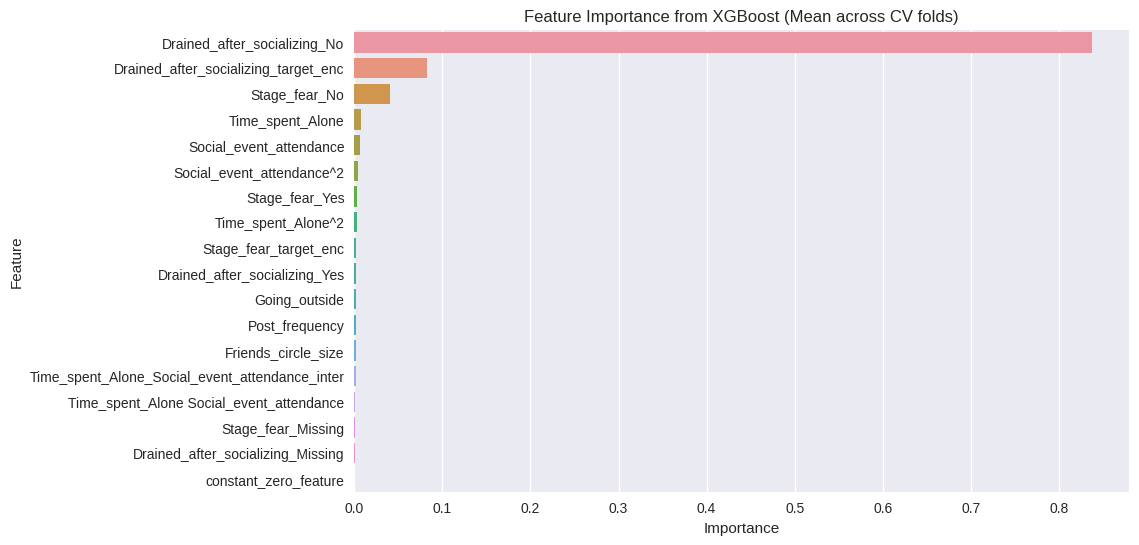


Feature Importances:
                                           Feature  Importance
1                     Drained_after_socializing_No    0.837927
3             Drained_after_socializing_target_enc    0.082941
9                                    Stage_fear_No    0.040893
12                                Time_spent_Alone    0.007134
7                          Social_event_attendance    0.006143
17                       Social_event_attendance^2    0.004434
10                                  Stage_fear_Yes    0.003478
15                              Time_spent_Alone^2    0.002993
11                           Stage_fear_target_enc    0.002173
2                    Drained_after_socializing_Yes    0.002030
5                                    Going_outside    0.002000
6                                   Post_frequency    0.001532
4                              Friends_circle_size    0.001435
14  Time_spent_Alone_Social_event_attendance_inter    0.001410
16        Time_spent_Alone Social

In [22]:
# Feature Importance
avg_feature_importances = feature_importances_sum / 5
feature_importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': avg_feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from XGBoost (Mean across CV folds)')
plt.show()
print("\nFeature Importances:")
print(feature_importance_df)

# Save OOF predictions
oof_df = pd.DataFrame({'id': train_id, 'oof_preds': oof_preds, 'target': y_encoded})
oof_df.to_csv('oof_predictions.csv', index=False)
print(f"\nOOF predictions saved to: oof_predictions.csv")
print(f"Sample OOF Head:\n{oof_df.head()}")

# Train final models
model_xgb.fit(X, y_encoded, sample_weight=[class_weights[y] for y in y_encoded])
model_lgb.fit(X, y_encoded, sample_weight=[class_weights[y] for y in y_encoded])
model_cat.fit(X, y_encoded, sample_weight=[class_weights[y] for y in y_encoded])

# Generate test predictions
test_pred_proba = (best_weights['w_xgb'] * model_xgb.predict_proba(X_test)[:, 1] +
                   best_weights['w_lgb'] * model_lgb.predict_proba(X_test)[:, 1] +
                   best_weights['w_cat'] * model_cat.predict_proba(X_test)[:, 1])
test_predictions = (test_pred_proba > threshold_ensemble).astype(int)
test_predictions_labels = le_target.inverse_transform(test_predictions)

# Create submission
submission_df = pd.DataFrame({'id': test_id, 'Personality': test_predictions_labels})
submission_df.to_csv('submission.csv', index=False)
print(f"\nSubmission file created at: submission.csv")
print(f"Shape: {submission_df.shape}")
print(f"Sample Submission Head:\n{submission_df.head()}")
print(f"Personality Value Counts:\n{submission_df['Personality'].value_counts()}")

# Validation Set Submission for Debugging

In [23]:
val_pred_proba = (best_weights['w_xgb'] * model_xgb.predict_proba(X_val)[:, 1] +
                  best_weights['w_lgb'] * model_lgb.predict_proba(X_val)[:, 1] +
                  best_weights['w_cat'] * model_cat.predict_proba(X_val)[:, 1])
val_predictions = (val_pred_proba > threshold_ensemble).astype(int)
val_predictions_labels = le_target.inverse_transform(val_predictions)
val_submission_df = pd.DataFrame({'id': train_df.loc[X_val.index, 'id'], 'Personality': val_predictions_labels})
val_submission_df.to_csv('submission_validation.csv', index=False)
print(f"\nValidation submission file created at: submission_validation.csv")
print(f"Shape: {val_submission_df.shape}")
print(f"Sample Validation Submission Head:\n{val_submission_df.head()}")


Validation submission file created at: submission_validation.csv
Shape: (3705, 2)
Sample Validation Submission Head:
        id Personality
5951  5951   Introvert
6848  6848   Introvert
9888  9888   Introvert
5839  5839   Extrovert
8769  8769   Extrovert
